In [5]:
import os
os.chdir('../../')

In [164]:

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets as datasets
from models import mlp,cmlp
from utilities import fits
from flax import linen as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss
from utilities.plot import plot_binary_class,plot_train_test
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
from functools import partial
from jax.flatten_util import ravel_pytree
import blackjax
from probml_utils.blackjax_utils import inference_loop
from sklearn.calibration import calibration_curve,CalibrationDisplay

# Dataset Visualization

In [59]:
X,Y =  datasets.make_moons(200, noise=0.2)

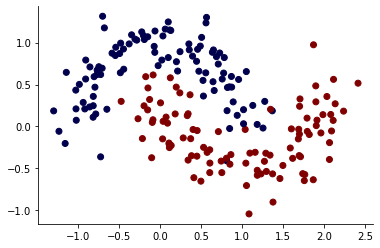

In [60]:
plt.scatter(X[:,0],X[:,1],c=Y,cmap='seismic')
sns.despine()

In [61]:
h=0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = jnp.meshgrid(jnp.arange(x_min, x_max, h),
                     jnp.arange(y_min, y_max, h))

In [62]:
xx.shape

(219, 286)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [64]:
X_train = jnp.array(X_train)
X_test = jnp.array(X_test)
y_train = jnp.array(y_train)
y_test = jnp.array(y_test)


# Single MLP

In [65]:
model = cmlp.cmlp([16,32,64,32,16,1],[nn.relu,nn.relu,nn.relu,nn.relu,nn.relu],[0.03]*5)

In [66]:
auxs = {
    "X" : X_train,
    "y" : y_train,
    "deterministic": True,
}

## Train

In [171]:
seed=0
params = model.init(jax.random.PRNGKey(seed), X_train, deterministic = True)
params, loss =  fits.fit(model, params,X_train,y_train,True,learning_rate=0.01, epochs=100)

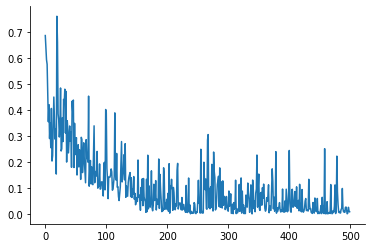

In [172]:
plt.plot(jnp.arange(0,loss.shape[0],1),loss)
sns.despine()

# 

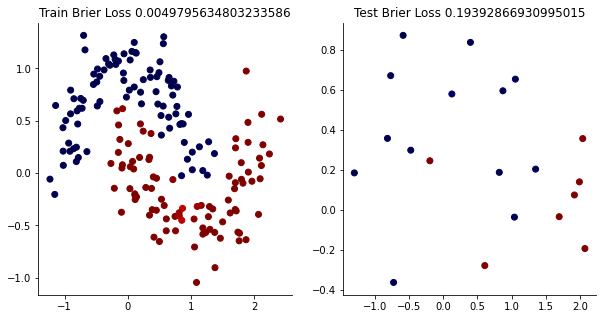

In [173]:
y_pred_train = model.apply(params, X_train, deterministic=True)
y_pred_test = model.apply(params, X_test, deterministic=True)
plot_train_test(X_train,X_test,y_pred_train,y_pred_test,y_train,y_test)

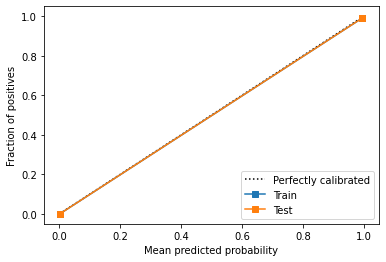

In [183]:
mlp_pred_train = model.apply(params,X_train,deterministic=True).reshape(y_train.shape)
mlp_pred_test = model.apply(params,X_test,deterministic=True).reshape(y_test.shape)
fig,ax = plt.subplots(1,1)
prob_true_mlp_train,prob_pred_mlp_train = calibration_curve(y_train,mlp_pred_train,n_bins=6)
prob_true_mlp_test,prob_pred_mlp_test = calibration_curve(y_train,mlp_pred_train,n_bins=6)

disp_train = CalibrationDisplay(prob_true_mlp_train,prob_pred_mlp_train,mlp_pred_train,estimator_name="Train")
disp_test = CalibrationDisplay(prob_true_mlp_test,prob_pred_mlp_test,mlp_pred_test,estimator_name="Test")

disp_train.plot(ax=ax)
disp_test.plot(ax=ax)

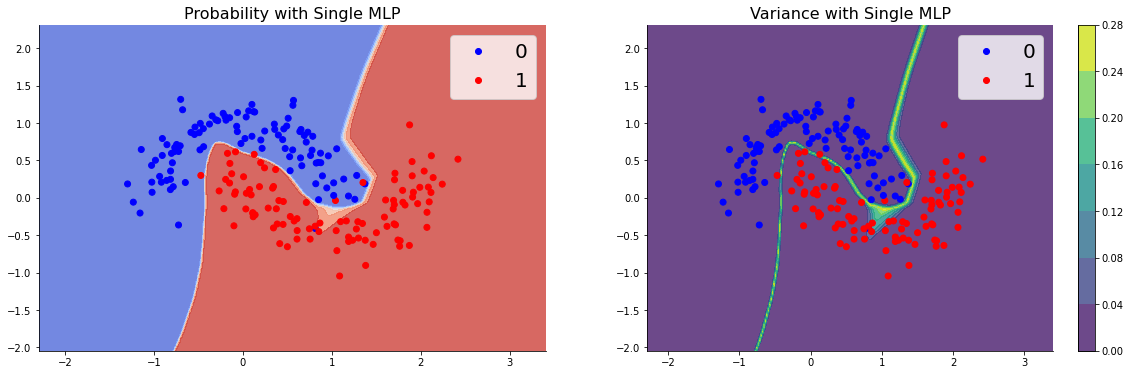

In [185]:
p =model.apply(params,jnp.c_[xx.ravel(), yy.ravel()],deterministic=True).reshape(xx.shape)
var = p*(1-p).reshape(xx.shape)

plot_binary_class(X,Y,xx,yy,p,var,titles=("Probability with Single MLP","Variance with Single MLP"))

# Deep Ensemble

In [27]:
params_lst= []
loss_lst =[]
for i in range(5):
    params =  model.init(jax.random.PRNGKey(i),X,deterministic=True)
    params,loss = fits.fit(model, params,X_train,y_train,True,learning_rate=0.01, epochs=100)
    params_lst.append(params)
    loss_lst.append(loss)

In [28]:
p_de_train_ensemble = []
p_de_test_ensemble = []

for i in range(5):
    params = params_lst[i]
    p =model.apply(params,X_train,deterministic=True)
    p_de_train_ensemble.append(p)
    p =model.apply(params,X_test,deterministic=True)
    p_de_test_ensemble.append(p)
ensemble_pred_train = jnp.array(p_de_train_ensemble).mean(axis=0).reshape(y_train.shape)
ensemble_pred_test= jnp.array(p_de_test_ensemble).mean(axis=0).reshape(y_test.shape)

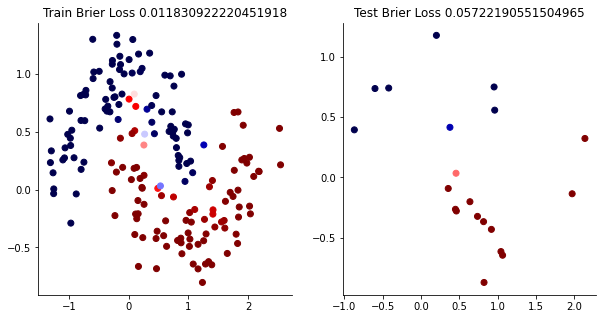

In [29]:
plot_train_test(X_train,X_test,ensemble_pred_train,ensemble_pred_test,y_train,y_test)

In [30]:
p_grid_ensemble = []

for i in range(5):
    params = params_lst[i]
    p =  model.apply(params,jnp.c_[xx.ravel(), yy.ravel()],deterministic=True).reshape(xx.shape)
    p_grid_ensemble.append(p)
ensemble_p_mean = jnp.array(p_grid_ensemble).mean(axis=0)
ensemble_p_sigma =  jnp.array(p_grid_ensemble).std(axis=0)
# ensemble_p_sigma = ensemble_p_mean*(1-ensemble_p_mean)


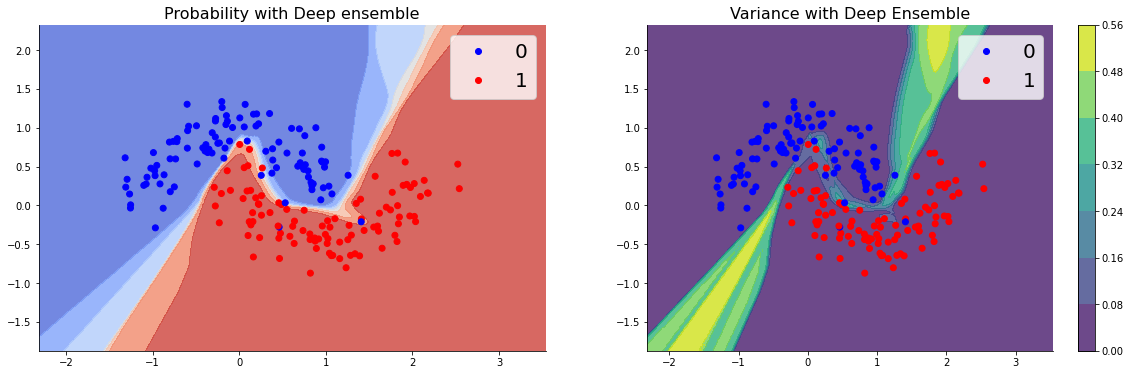

In [31]:
plot_binary_class(X,Y,xx,yy,ensemble_p_mean,ensemble_p_sigma,titles=("Probability with Deep ensemble","Variance with Deep Ensemble"))

### MC Dropout

In [32]:
y_stacks = []

@jax.jit
def func(params, i):
    z = model.apply(params, jnp.c_[xx.ravel(), yy.ravel()], deterministic=False, 
                    rngs={"dropout": jax.random.PRNGKey(i)}).reshape(xx.shape)
    return z
y_stacks = jax.vmap(fun=func, in_axes=(None, 0))(params, jnp.arange(50))

In [33]:
mc_pred_mean= jnp.array(y_stacks).mean(axis=0).reshape(xx.shape)
mc_pred_sigma = (jnp.array(y_stacks).std(axis=0)).reshape(yy.shape)

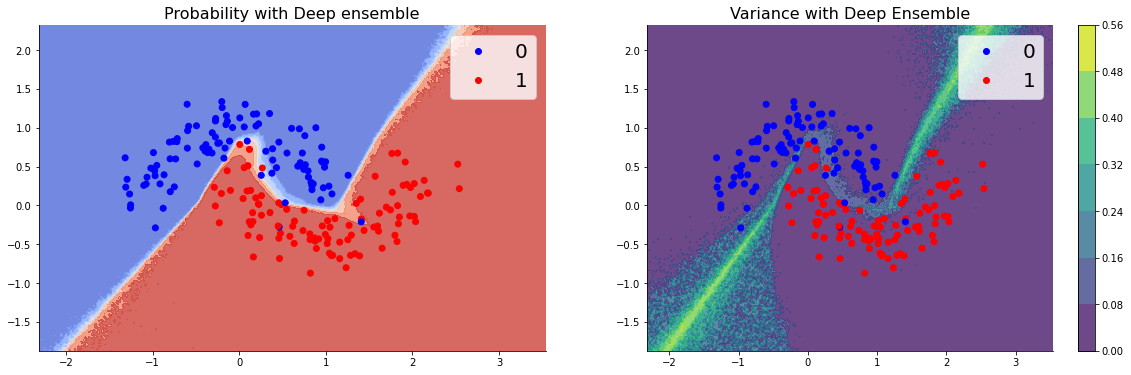

In [34]:
plot_binary_class(X,Y,xx,yy,mc_pred_mean,mc_pred_sigma,titles=("Probability with Deep ensemble","Variance with Deep Ensemble"))

# NUTS

In [ ]:
def bnn_log_joint(params:dict, X, y, model):
    """
    computes the numerator term of the posterior funtion.

    params: dictionary initalized by model 
    X: shape-(n_samples,2) training points 
    y: shape-(n_samples,) labels for training points
    model: bnn model
    """
    
    logits = model.apply(params, X,deterministic=True).ravel()
    
    flatten_params, _ = ravel_pytree(params)
    log_prior = tfd.Normal(0.0, 1.0).log_prob(flatten_params).sum()
    log_likelihood = tfd.Bernoulli(logits=logits).log_prob(y).sum()
    log_joint = log_prior + log_likelihood
    return log_joint

bnn_log_joint_partial =partial(bnn_log_joint,X=X,y=Y,model=model)
bnn_log_joint_partial(params)

DeviceArray(-5148.6333, dtype=float32)

In [ ]:
num_warmup = 1000
potential = bnn_log_joint_partial
key = jax.random.PRNGKey(314)
key_samples, key_init, key_warmup, key = jax.random.split(key, 4)
adapt = blackjax.window_adaptation(blackjax.nuts, potential, num_warmup)
final_state, kernel, _ = adapt.run(key_warmup, params)
num_samples = 500
states,infos = inference_loop(key_samples, kernel, final_state, num_samples)

In [ ]:
seed = jax.random.PRNGKey(0)
def one_step(carry, state):
    params_cur = state.position
    samples = tfd.Bernoulli(probs=model.apply(params_cur,jnp.c_[xx.ravel(), yy.ravel()],deterministic=True)).sample(seed=seed)
    return carry, samples
_, y_stacks = jax.lax.scan(one_step, None, states)

mcmc_pred_mean = jnp.array(y_stacks).mean(axis=0).reshape(xx.shape)
mcmc_pred_sigma = jnp.array(y_stacks).std(axis=0).reshape(yy.shape)

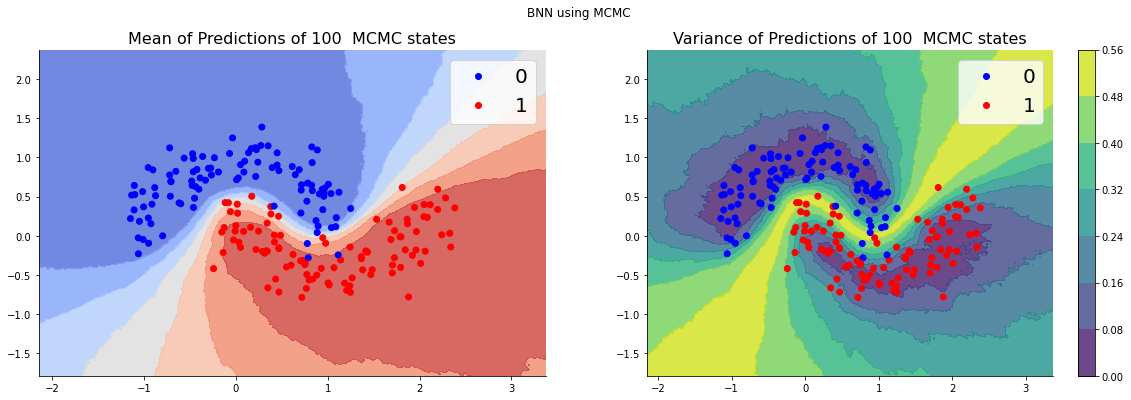

In [ ]:
titles_mcmc = ("Mean of Predictions of 100  MCMC states","Variance of Predictions of 100  MCMC states")
plot_binary_class(X_scatters=X,y_scatters=Y,XX1_grid=xx,
XX2_grid = yy,grid_preds_mean=mcmc_pred_mean,grid_preds_sigma= mcmc_pred_sigma,titles=titles_mcmc)
plt.suptitle("BNN using MCMC")
plt.savefig("MCMC_moons.pdf")

# GP


Name : gp_classification
Objective : 55.86067325455106
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp_classification.  |  value  |  constraints  |  priors
  rbf.variance        |    1.0  |      +ve      |        
  rbf.lengthscale     |    1.0  |      +ve      |        
-55.86067325455106


Optimization restart 1/5, f = 34.71910412336713
Optimization restart 2/5, f = 39.73744512608134
Optimization restart 3/5, f = 41.07507506902982
Optimization restart 4/5, f = 43.28547528293388
Optimization restart 5/5, f = 42.16477095079003

Name : gp_classification
Objective : 44.26082717502756
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp_classification.  |               value  |  constraints  |  priors
  rbf.variance        |   8.557668037072586  |      +ve      |        
  rbf.lengthscale     |  0.6868481814919217  |      +ve      |        


 /home/anand/anaconda3/envs/srip/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


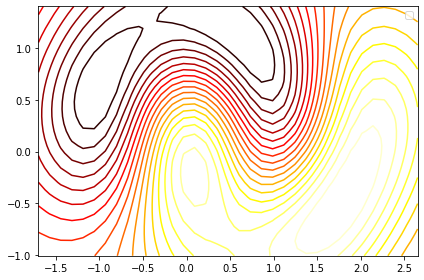

In [53]:
import GPy
import numpy as jnp
h=0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = jnp.meshgrid(jnp.arange(x_min, x_max, h),
                     jnp.arange(y_min, y_max, h))

model = GPy.models.GPClassification(X_train, y_train.reshape(-1,1))
print(model)
print(model.log_likelihood())
model.optimize(messages=True)
model.optimize_restarts(num_restarts=5)
print(model)
model.plot_f()
probability_gp,na = model.predict(jnp.c_[xx.ravel(), yy.ravel()])

In [55]:
probability_gp = probability_gp.reshape(xx.shape)
sigma_gp = jnp.sqrt(probability_gp*(1-probability_gp)).reshape(xx.shape)


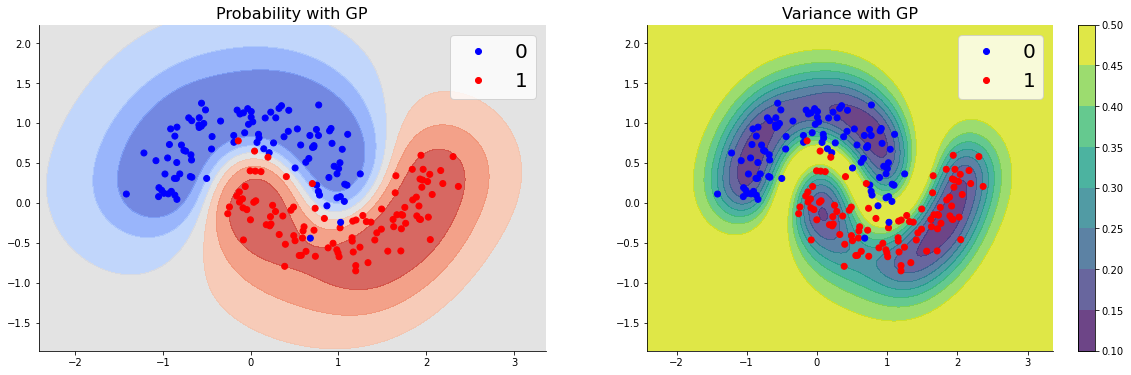

In [56]:
plot_binary_class(X,Y,xx,yy,probability_gp,sigma_gp,titles=("Probability with GP","Variance with GP"))